In [4]:
from iexfinance.stocks import Stock
from iexfinance.altdata import get_social_sentiment
from datetime import datetime
from iexfinance.stocks import get_historical_data
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


In [5]:
'''read my token from my local file'''
f= open("Key.txt","r")
TK = f.read()

             open   high    low  close   volume
date                                           
2019-07-11  16.65  16.70  16.33  16.47  1145810
2019-07-12  16.60  16.75  16.33  16.40  1399692
2019-07-15  16.58  16.66  16.41  16.45  1491340
2019-07-16  16.50  16.55  16.06  16.07  1327736
2019-07-17  16.10  16.10  15.36  15.58  2816948
get 328 days data in total, predict 14 days


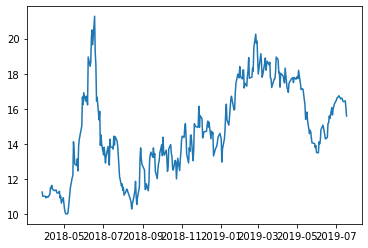

In [6]:
"""
1. download data
2. prepare dataframe
3. draw chart 
4. split train & test set
"""

'''download data'''
start = datetime(2015, 3, 1)
end = datetime(2019, 7, 17)
#df is the whole dataframe downloaded from website 
df = get_historical_data("BILI", start, end,token=TK,output_format='pandas')
print(df.tail())


'''prepare for the date we use
1. copy the dataframe into a new_data
2. rename the key 
    Close --> y
    Date --> ds
'''
sorted_df = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
for i in range(0,len(sorted_df)):
    new_data['ds'][i] = sorted_df.index[i]
    new_data['y'][i] = sorted_df['close'][i]
    
    

'''draw figure'''
# df.loc['2018-04-02']
# index = df.index
# print(index)
plt.plot(df['close'])



'''split data into training and validation'''
DAYS = 14
split = len(new_data) - DAYS
train = new_data[:split]
valid = new_data[split:]
print('get %d days data in total, predict %d days'%(len(new_data),DAYS))

In [31]:
print(new_data)

                      ds      y
0    2018-03-28 00:00:00  11.24
1    2018-03-29 00:00:00     11
2    2018-04-02 00:00:00     11
3    2018-04-03 00:00:00  10.91
4    2018-04-04 00:00:00  10.97
5    2018-04-05 00:00:00  10.98
6    2018-04-06 00:00:00  10.94
7    2018-04-09 00:00:00   11.1
8    2018-04-10 00:00:00   11.5
9    2018-04-11 00:00:00  11.48
10   2018-04-12 00:00:00  11.62
11   2018-04-13 00:00:00   11.4
12   2018-04-16 00:00:00  11.33
13   2018-04-17 00:00:00  11.32
14   2018-04-18 00:00:00  11.35
15   2018-04-19 00:00:00  11.35
16   2018-04-20 00:00:00  11.19
17   2018-04-23 00:00:00  11.19
18   2018-04-24 00:00:00  11.29
19   2018-04-25 00:00:00   10.9
20   2018-04-26 00:00:00     11
21   2018-04-27 00:00:00  10.61
22   2018-04-30 00:00:00  10.92
23   2018-05-01 00:00:00  10.58
24   2018-05-02 00:00:00  10.26
25   2018-05-03 00:00:00  10.08
26   2018-05-04 00:00:00   9.99
27   2018-05-07 00:00:00     10
28   2018-05-08 00:00:00  10.27
29   2018-05-09 00:00:00  10.65
..      

In [76]:
"""
FB prophet sections
1. test mode
2. predict mode
"""
MODE = 'B'   # T for checking mode, P for predicting mode
model = Prophet()

if MODE == 'T':
    print('test model...')
    model.fit(train)
else:
    print('predict next %d days' %(DAYS))
    model.fit(new_data)
FutureDays = model.make_future_dataframe(periods=DAYS)
forecast = model.predict(FutureDays)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predict next 14 days


D:\Work\Aconda\AnacodaPython3.7\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


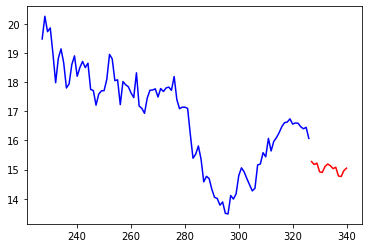

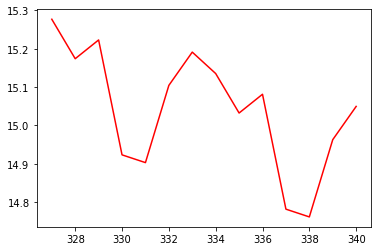

In [77]:
'''draw chart'''
if MODE == 'T':
    forecast_valid = forecast['yhat'][split:]
    valid['Predictions'] = forecast_valid.values

    plt.figure(1)
    plt.plot(train['y'],'b') #blue for past groud truth
    plt.plot(valid['y'],'r') #red stands for true
    plt.plot(valid['Predictions'],'y') # yellow stands for prediction

    plt.figure(2)
    plt.plot(valid['y'][-100:],'r')
    plt.plot(valid['Predictions'],'y')
else:
    predict_close = forecast['yhat'][-DAYS:]
    plt.figure(1)
    plt.plot(new_data['y'][-100:], 'b')
    plt.plot(predict_close,'r')
    
    plt.figure(2)
    plt.plot(predict_close,'r')

In [58]:
# from keras.models import Sequential

new_data2 = new_data.copy()
new_data2.index = new_data2.ds
new_data2.drop('ds', axis=1, inplace=True)

In [78]:
'''
train the LSTM model with the previous split inputs
'''
'''0. copy data into a new frame'''
new_data2 = new_data.copy()
new_data2.index = new_data2.ds
new_data2.drop('ds', axis=1, inplace=True)

dataset = new_data2.values
split=len(new_data) - DAYS
CYCLE = 60
'''1. scale the data'''
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

'''2. build X_train & Y_train'''
x_train, y_train = [], []
for i in range(CYCLE,split):
    x_train.append(scaled_data[i-CYCLE:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

'''3. reshape the data'''
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

'''4. build model and train'''
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

D:\Work\Aconda\AnacodaPython3.7\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(253, 60, 1)
Epoch 1/5
 - 12s - loss: 0.0176
Epoch 2/5
 - 10s - loss: 0.0090
Epoch 3/5
 - 11s - loss: 0.0073
Epoch 4/5
 - 12s - loss: 0.0051
Epoch 5/5
 - 12s - loss: 0.0056


D:\Work\Aconda\AnacodaPython3.7\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


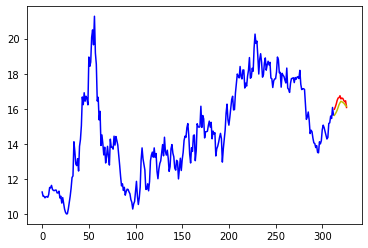

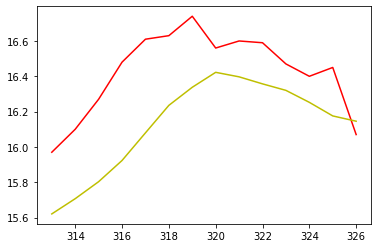

In [64]:
#predicting 246 values, using past 60 from the train data
'''
Test model by using true data as ground truth
'''
'''1. reshape the input and scale'''
inputs = new_data2[len(new_data2) - len(valid) - CYCLE:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

'''2. build X_test'''
X_test = []
for i in range(CYCLE,inputs.shape[0]):
    X_test.append(inputs[i-CYCLE:i,0])
X_test = np.array(X_test)

'''3.reshape X_test'''
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

'''4. predict price'''
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

'''5. draw chart'''
train = new_data[:split]
valid = new_data[split:]
valid['FPredictions'] = closing_price

plt.figure(1)
plt.plot(train['y'],'b')
plt.plot(valid['y'],'r') #red stands for true
plt.plot(valid['FPredictions'],'y') # yellow stands for fake prediction

plt.figure(2)
plt.plot(valid['y'],'r')
plt.plot(valid['FPredictions'],'y')


[15.337923, 15.24929, 15.224982, 15.218322, 15.216498, 15.215999, 15.215861, 15.215825, 15.215815, 15.215812, 15.21581, 15.21581, 15.21581, 15.21581]


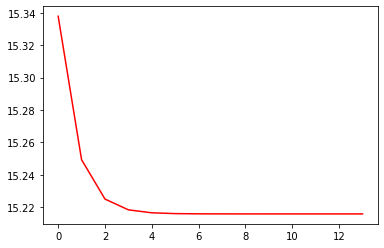

In [84]:
'''
predict data by using generated dataset
'''
predict = []
X_test_1 = []

'''prepare for the input'''
input1 = new_data2[len(new_data2) - len(valid) - CYCLE:].values
input1 = input1.reshape(-1,1)
input1 = scaler.transform(input1)

'''1. generate day 1 by using the last 60 input'''
X_test_1.append(input1[0:CYCLE,0])
X_test_1 = np.array(X_test_1)
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0],X_test_1.shape[1],1))
closing_price = model.predict(X_test_1)
closing_price_r = scaler.inverse_transform(closing_price)
predict.append(closing_price_r[0][0])

'''2. day 2 ~ day DAYS'''
for i in range(0, DAYS-1):
    temp = np.append(X_test_1[0], closing_price)
    temp = np.delete(temp, 0)
    temp = np.reshape(temp, (1, temp.shape[0]))
    temp = np.reshape(temp, (temp.shape[0],temp.shape[1], 1))
    
    closing_price = model.predict(temp)
    closing_price_r = scaler.inverse_transform(closing_price)
    predict.append(closing_price_r[0][0])

'''3. draw chart'''
# model2 = Prophet()
# model2.fit(new_data)
# FutureDays = model2.make_future_dataframe(periods=DAYS)
print(predict)

plt.figure(1)
plt.plot(predict,'r') # yellow stands for fake prediction